In [1]:
!pip install -q transformers datasets accelerate bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 22.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.5 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install -U fsspec datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 8.2 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: datasets
    Found existing installation: datasets 3.6.0
    Uninstalling datasets-3.6.0:
      Successfully uninstalled datasets-3.6.0


## Load the Model+Tokenizer

In [5]:
import os, random, itertools, math, torch
from torch.utils.data import DataLoader
from transformers import (
    AutoTokenizer, AutoModelForMaskedLM,
    get_cosine_schedule_with_warmup
)
from torch.optim import AdamW
from datasets import load_dataset
import gc
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
# Clear GPU memory at start
torch.cuda.empty_cache()
gc.collect()

0

In [7]:
model_id = "google/muril-base-cased"

tokenizer = AutoTokenizer.from_pretrained(model_id)

model = AutoModelForMaskedLM.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,   # bfloat16 = cheap & safe
    device_map="auto",            # or set to "cuda:0"
    low_cpu_mem_usage=True,
)

# enable gradient checkpointing
model.gradient_checkpointing_enable()

mask_id  = tokenizer.mask_token_id
cls_id   = tokenizer.cls_token_id
sep_id   = tokenizer.sep_token_id

print(f"{tokenizer.mask_token=}  {mask_id}")

tokenizer_config.json:   0%|          | 0.00/206 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/113 [00:00<?, ?B/s]

2025-07-27 11:37:55.670773: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753616275.873276      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753616275.931533      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


pytorch_model.bin:   0%|          | 0.00/953M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/953M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/muril-base-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer.mask_token='[MASK]'  103


## Dataset

Including adding masks with rand prob and padding

In [8]:
raw_ds = load_dataset(
    "ai4bharat/indic-instruct-data-v0.1",
    "anudesh",
    split="hi",
    cache_dir="./data",
)
print("raw len:", len(raw_ds))

README.md: 0.00B [00:00, ?B/s]

en-00000-of-00001.parquet:   0%|          | 0.00/8.41M [00:00<?, ?B/s]

hi-00000-of-00001.parquet:   0%|          | 0.00/12.5M [00:00<?, ?B/s]

Generating en split:   0%|          | 0/5234 [00:00<?, ? examples/s]

Generating hi split:   0%|          | 0/7577 [00:00<?, ? examples/s]

raw len: 7577


In [9]:
max_len          = 256              # inc 512
mask_ratio_min   = 0.15
mask_ratio_max   = 0.99

def join_dialogue(msgs):
    """
    [ {role, content}, ... ]  ->  one flat string with explicit [SEP] boundaries
    We expect first msg=user, second msg=assistant.
    """
    u = msgs[0]["content"].strip()
    a = msgs[1]["content"].strip()
    return f"User: {u} {tokenizer.sep_token} Assistant: {a}"

def apply_random_mask(example):
    text = join_dialogue(example["messages"])
    enc  = tokenizer(text,
                     truncation=True, max_length=max_len,
                     padding="max_length")
    ids  = enc["input_ids"]
    labels = [-100] * len(ids)   # -100 -> ignored by CE-loss

    # find assistant region (everything after first [SEP])
    if sep_id not in ids:
        return {**enc, "labels": labels}
    sep_pos = ids.index(sep_id)
    cand = [i for i in range(sep_pos+1, len(ids))
            if ids[i] not in (tokenizer.pad_token_id,
                              cls_id, sep_id)]
    if not cand:
        return {**enc, "labels": labels}

    # variable mask ratio
    m_ratio = random.uniform(mask_ratio_min, mask_ratio_max)
    n_mask  = max(1, int(len(cand) * m_ratio))
    chosen  = random.sample(cand, n_mask)

    for idx in chosen:
        labels[idx] = ids[idx] # remember ground-truth
        dice = random.random()
        if dice < 0.8:  # 80 %
            ids[idx] = mask_id
        elif dice < 0.9: # 10 %
            ids[idx] = random.randint(0, tokenizer.vocab_size - 1)
        # else leave token unchanged (10 %)

    enc["input_ids"]    = ids
    enc["labels"]       = labels
    return enc

proc_ds = raw_ds.map(apply_random_mask, remove_columns=raw_ds.column_names, 
                     num_proc=16, batch_size=1000)
proc_ds.set_format(type="torch")
print(proc_ds[0]["input_ids"][:30], "\nlabels:", proc_ds[0]["labels"][:30])

Map (num_proc=16):   0%|          | 0/7577 [00:00<?, ? examples/s]

tensor([   104,  48467,    133,  19699,   1114,    126,  19202,   3937,   1126,
          3021,  86260,    492,    105,  20978,    133,   7231,    103,   1124,
        191772,    103,    103,    103,    103,    103,  19202, 177242,   1117,
           103, 131025,    103]) 
labels: tensor([ -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  1365,  -100,   119,  4254,
        19699,  1117,   126,   120, 19202,  3937,  1117,  3248,  4075,  1114])


In [10]:
# use smaller dataset subset
subset_size = min(10000, len(proc_ds))
proc_ds = proc_ds.select(range(subset_size))

train_ds = proc_ds.shuffle(seed=42).select(range(int(0.95*len(proc_ds))))
val_ds   = proc_ds.select(range(int(0.95*len(proc_ds)), len(proc_ds)))

In [11]:
# prompt: pick a random sample and decode it to visualize the data

sample = random.choice(proc_ds)
decoded_input = tokenizer.decode(sample["input_ids"], skip_special_tokens=False)
print("Decoded Input:")
print(decoded_input)

# Decode the labels to see the original tokens that were masked
labels_to_decode = [label for label in sample["labels"] if label != -100]
decoded_labels = tokenizer.decode(labels_to_decode, skip_special_tokens=False)
print("\nDecoded Labels (Original masked tokens):")
decoded_labels

Decoded Input:
[CLS] User : आवर्त सारणी के इतिहास और उपयोगों की व्याख्या करें । [SEP] Assistant : [MASK] [MASK] [MASK] [MASK] [MASK] आज, [MASK] [MASK] [MASK] की [MASK] दुनिया में तल्लीन होंगे [MASK] [MASK] रसायन [MASK] [MASK] [MASK] [MASK] उपकरण है जो [MASK] [MASK] [MASK] आधारशिला रहा है [MASK] आवर्त सारणी [MASK] [MASK] [MASK] [MASK]बद्ध [MASK] [MASK],ଇମتا परमाणु संख्या ( [MASK] [MASK] नाभिक में [MASK] [MASK] संख्या [MASK], [MASK] विन्यास और [MASK] दिनुभएको [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] है । [MASK] में पंक्ति [MASK] খোদিত [MASK] [MASK] ) [MASK] स्तंभ ( समूह [MASK] होते हैं [MASK] जिनमें [MASK] समूह [MASK] तत्व [MASK] संख्या [MASK] संयोजकता [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] को [MASK] पाकिस्तान हैं । आवर्त [MASK] का इतिहासः [MASK] शुरुआत [MASK] [MASK] [MASK] उनके [MASK] [MASK] [MASK] [MASK] [MASK] अरस्तू और [MASK]ವಿಯಾ [MASK] [MASK] [MASK] நெடுஞ்சாலையில் भारतीय [MASK] [MASK]त्तिों से [MASK] [MASK] सकता है [MASK] उनका मानना था [MASK] पदार्थ चार मूल तत्वों से [MASK] [MAS

'Assistant नमस्ते, सम्मानित पाठकों! हम आवर्त सारणी की आकर्षक, जो विज्ञान में एक मौलिक वैज्ञानिक प्रगति की । तत्वों का एक सारणी प्रदर्शन है जो उनकी परमाणु परमाणु के नाभिक प्रोटॉन की ) इलेक्ट्रॉन और आवर्ती रासायनिक गुणों के आधार पर व्यवस्थित तालिका मेंयाँ ( अवधियाँ और स्तंभ ), प्रत्येक समूह के समान संख्या में इलेक्ट्रॉनों के कारण समान गुणों प्रदर्शित करते आवर्त सारणी का प्रारंभिकः तत्वों और उनके गुणों की अवधारणा का पता प्राक्सागोरस जैसे प्राचीन भारतीय और यूनानी दार्शनिक लगाया जा । कि बना हैः,, अग्नि और जल 2. डाल का सिद्धांत 1803 में जॉन डाल्टन आधुनिक परमाणु प्रस्ताव, कि तत्व परमाणु अविभाज्य बने हैं, और यौगिक तब हैं जब पूर्ण अनुपात में जुड़ हैं । 3. मेंडेलीव की आवर्त 1869, रसायन दिमित्र'

In [10]:
batch = proc_ds[0:4]
for k,v in batch.items(): print(k, v.shape)

input_ids torch.Size([4, 256])
token_type_ids torch.Size([4, 256])
attention_mask torch.Size([4, 256])
labels torch.Size([4, 256])


## Training

In [11]:
actual_batch_size = 4               # Increase this
accumulation_steps = 8              
effective_batch_size = actual_batch_size * accumulation_steps

train_loader = DataLoader(train_ds, batch_size=actual_batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=actual_batch_size, shuffle=True)

In [12]:
def accuracy_buckets(logits, labels, attn):
    """
    Returns:
        total_loss   (float, per-token, NOT per-sequence)
        global_acc   (float)
        bucket_acc   (list[4])  # ≤.25, .25-.5, .5-.75, >.75
    """
    # logits: [B,T,V]  labels: [B,T]
    with torch.no_grad():
        pred   = logits.argmax(-1)
        mask   = labels != -100                  # only masked positions count
        correct= (pred == labels) & mask

        # ---- global ----
        tot_masked = mask.sum().item()
        tot_corr   = correct.sum().item()
        global_acc = tot_corr / tot_masked if tot_masked else 0.0

        # ---- buckets by sample-level mask ratio ----
        bucket_corr  = [0,0,0,0]
        bucket_total = [0,0,0,0]
        edges = (0.25, 0.50, 0.75, 1.01)         # last edge slightly >1

        for b in range(labels.size(0)):
            n_mask = mask[b].sum().item()
            if n_mask == 0:                       # should be rare
                continue
            # denominator = real tokens (ignore pads)
            seq_len = attn[b].sum().item()
            ratio   = n_mask / seq_len
            # bucket index
            for i,edge in enumerate(edges):
                if ratio <= edge:
                    bucket_total[i]  += n_mask
                    bucket_corr[i]   += correct[b].sum().item()
                    break

        bucket_acc = [c/t if t else 0.0 for c,t in zip(bucket_corr, bucket_total)]
    return global_acc, bucket_acc

In [13]:
from itertools import islice

@torch.no_grad()
def evaluate(model, val_loader, batches=4):
    model.eval()
    tot_loss, tot_acc, bucket_hits = 0., 0., [0,0,0,0]
    for batch in islice(val_loader, batches):
        batch = {k:v.to(device) for k,v in batch.items()}
        out   = model(**batch)
        loss  = out.loss.item()
        tot_loss += loss
        acc, bucket_acc = accuracy_buckets(out.logits, batch["labels"], batch["attention_mask"])
        tot_acc += acc
        bucket_hits = [h+a for h,a in zip(bucket_hits, bucket_acc)]
        
        del out
        torch.cuda.empty_cache()
        
    n = batches
    val_loss = tot_loss / n
    val_acc  = tot_acc  / n
    bucket_acc = [b/n for b in bucket_hits]
    return val_loss, val_acc, bucket_acc

In [14]:
from tqdm.auto import tqdm

base_lr = 2e-4
optim = AdamW(model.parameters(), lr=base_lr, weight_decay=0.01)

num_epochs           = 1
steps_per_epoch      = len(train_loader)
total_steps          = num_epochs * steps_per_epoch
warmup_steps         = int(0.06 * total_steps)
sched = get_cosine_schedule_with_warmup(optim, warmup_steps, total_steps)

log_every   = 100
global_step = 0
losses, val_losses = [], []
accs, val_accs = [], []

model.train()
for epoch in range(num_epochs):
    pbar = tqdm(train_loader, total=steps_per_epoch,
                desc=f"Epoch {epoch}", leave=False, dynamic_ncols=True)

    running_loss = 0.0
    running_acc  = 0.0
    
    for step, batch in enumerate(pbar, 1):
        batch = {k:v.to(device) for k,v in batch.items()}
        
        out = model(**batch)
        loss = out.loss / accumulation_steps  # Scale loss for accumulation
        
        loss.backward()
        
        # ── on-the-fly training accuracy ───────────────────────────────────────
        with torch.no_grad():
            acc, _ = accuracy_buckets(out.logits, batch["labels"], batch["attention_mask"])
        
        running_loss += loss.item() * accumulation_steps  # Unscale for logging
        running_acc  += acc
        
        losses.append(loss.item() * accumulation_steps)
        accs.append(acc)
        
        # Gradient accumulation step
        if step % accumulation_steps == 0:
            optim.step()
            optim.zero_grad()
            sched.step()
            global_step += 1
            
            # Memory cleanup
            torch.cuda.empty_cache()
            
            # Validation check
            if global_step % log_every == 0:
                val_loss, val_acc, val_buckets = evaluate(model, val_loader)
                val_losses.append(val_loss)
                val_accs.append(val_acc)
                print(f"\nStep {global_step:6d} | "
                      f"train_loss {running_loss/step:.4f}  "
                      f"train_acc {running_acc/step:.3f} | "
                      f"val_loss {val_loss:.4f}  val_acc {val_acc:.3f} | "
                      f"bucket_acc {['{:.3f}'.format(x) for x in val_buckets]}\n")
                model.train()
        
        # Clean up variables
        del out, loss
        
        if step % 20 == 0 or step == 1:
            pbar.set_postfix(loss = running_loss/step,
                             acc  = running_acc / step)

    if step % accumulation_steps != 0:
        optim.step()
        optim.zero_grad()
        sched.step()

print("Training khatam!")

# Final cleanup
torch.cuda.empty_cache()
gc.collect()

Epoch 0:   0%|          | 0/1800 [00:00<?, ?it/s]


Step    100 | train_loss 4.0208  train_acc 0.380 | val_loss 2.5527  val_acc 0.546 | bucket_acc ['0.539', '0.688', '0.328', '0.056']


Step    200 | train_loss 3.4724  train_acc 0.427 | val_loss 2.1680  val_acc 0.584 | bucket_acc ['0.179', '0.762', '0.416', '0.071']

Training khatam!


72

## Plot

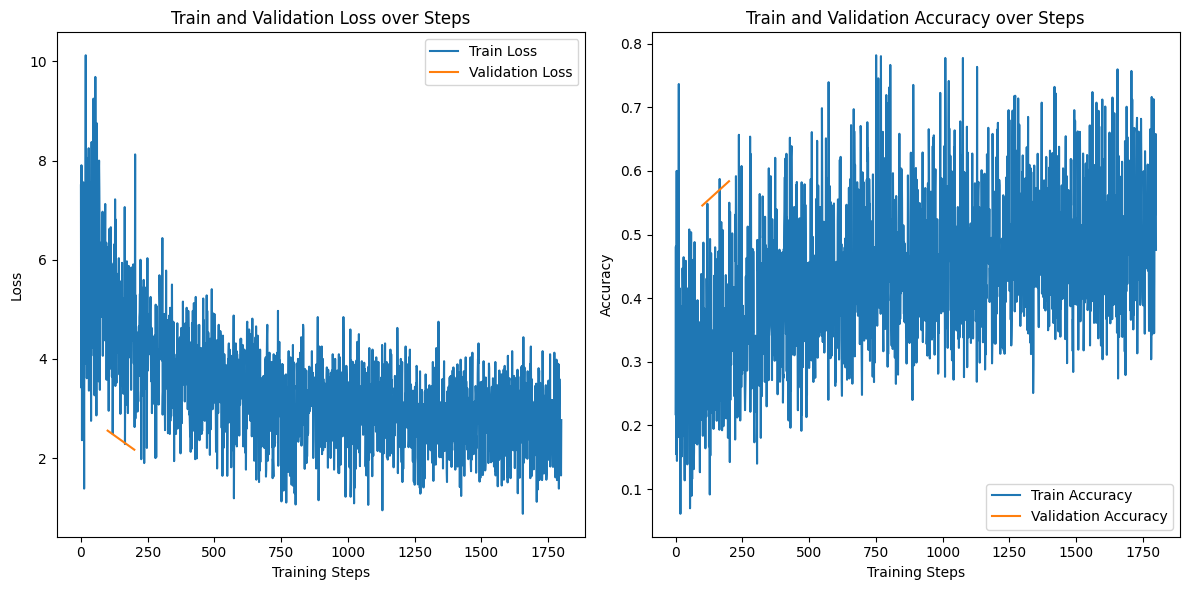

In [16]:
import matplotlib.pyplot as plt

# Plotting loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(losses, label='Train Loss')
val_x = [i * log_every for i in range(1, len(val_losses) + 1)]
plt.plot(val_x, val_losses, label='Validation Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Train and Validation Loss over Steps')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(accs, label='Train Accuracy')
plt.plot(val_x, val_accs, label='Validation Accuracy')
plt.xlabel('Training Steps')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy over Steps')
plt.legend()

plt.tight_layout()
plt.show()

## Testing

In [17]:
import torch
import os

save_dir = "diffusionlm-finetuned"
os.makedirs(save_dir, exist_ok=True)

torch.save(model.state_dict(), os.path.join(save_dir, "pytorch_model.bin"))
tokenizer.save_pretrained(save_dir)

model.config.save_pretrained(save_dir)

In [18]:
import torch
from transformers import AutoTokenizer, AutoModel

model = AutoModel.from_pretrained(save_dir)
tokenizer = AutoTokenizer.from_pretrained(save_dir)
model.eval()

def generate_response(query, max_length=512):
    inputs = tokenizer(query, return_tensors="pt", truncation=True, max_length=max_length)
    
    with torch.no_grad():
        outputs = model(**inputs)
        
        if hasattr(outputs, 'prediction_scores'):
            logits = outputs.prediction_scores
        elif hasattr(outputs, 'logits'):
            logits = outputs.logits
        else:
            raise ValueError("Cannot find prediction logits in model output")
        
        predicted_ids = torch.argmax(logits, dim=-1)
        
        response = tokenizer.decode(predicted_ids[0], skip_special_tokens=True)
    
    return response

query = "फ़्रांस की राजधानी कौनसी है?"
response = generate_response(query)
print(f"Query: {query}")
print(f"Response: {response}")

Some weights of BertModel were not initialized from the model checkpoint at diffusionlm-finetuned and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ValueError: Cannot find prediction logits in model output

In [19]:
import torch
from transformers import AutoTokenizer, AutoModel

model = AutoModel.from_pretrained(save_dir)
tokenizer = AutoTokenizer.from_pretrained(save_dir)
model.eval()

query = "फ़्रांस की राजधानी कौनसी है?"
inputs = tokenizer(query, return_tensors="pt", truncation=True, max_length=512)

with torch.no_grad():
    outputs = model(**inputs)
    print(f"Output type: {type(outputs)}")
    print(f"Output attributes: {dir(outputs)}")
    
    if hasattr(outputs, 'keys'):
        print(f"Output keys: {list(outputs.keys())}")
    
    for attr in ['last_hidden_state', 'pooler_output', 'hidden_states', 'attentions']:
        if hasattr(outputs, attr):
            value = getattr(outputs, attr)
            if value is not None:
                print(f"{attr}: {value.shape if hasattr(value, 'shape') else type(value)}")

print(f"\nModel type: {type(model)}")
print(f"Model config: {model.config}")

Some weights of BertModel were not initialized from the model checkpoint at diffusionlm-finetuned and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Output type: <class 'transformers.modeling_outputs.BaseModelOutputWithPoolingAndCrossAttentions'>
Output attributes: ['__annotations__', '__class__', '__class_getitem__', '__contains__', '__dataclass_fields__', '__dataclass_params__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__ior__', '__iter__', '__le__', '__len__', '__lt__', '__match_args__', '__module__', '__ne__', '__new__', '__or__', '__post_init__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__ror__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', 'attentions', 'clear', 'copy', 'cross_attentions', 'fromkeys', 'get', 'hidden_states', 'items', 'keys', 'last_hidden_state', 'move_to_end', 'past_key_values', 'pooler_output', 'pop', 'popitem', 'setdefault', 'to_tuple', 'update', 'values']
Output keys: ['last_hidden_state', 'pooler

In [22]:
from transformers import AutoModelForMaskedLM

model = AutoModelForMaskedLM.from_pretrained(save_dir)
tokenizer = AutoTokenizer.from_pretrained(save_dir)
model.eval()

query = "फ़्रांस की [MASK] कौनसी है|"
inputs = tokenizer(query, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    print(f"Output keys: {list(outputs.keys())}")
    
    if hasattr(outputs, 'logits'):
        print(f"Logits shape: {outputs.logits.shape}")
        
        mask_token_index = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]
        mask_logits = outputs.logits[0, mask_token_index, :]
        predicted_token_id = torch.argmax(mask_logits, dim=-1)
        predicted_token = tokenizer.decode(predicted_token_id)
        
        print(f"Predicted token: {predicted_token}")

Output keys: ['logits']
Logits shape: torch.Size([1, 9, 197285])
Predicted token: राजधानी


In [21]:
query = "भारत की राजधानी [MASK] है।" 
inputs = tokenizer(query, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    if hasattr(outputs, 'logits'):
        mask_token_index = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]
        mask_logits = outputs.logits[0, mask_token_index, :]
        predicted_token_id = torch.argmax(mask_logits, dim=-1)
        predicted_token = tokenizer.decode(predicted_token_id)
        print(f"Predicted: {predicted_token}")

Predicted: दिल्ली


In [ ]:
repo_id = "<your_hf_username>/diffusionlm-finetuned"
model.push_to_hub(
    repo_id,
    token="your_hf_token",
    private=True,                      # drop this if the repo can be public
    commit_message="Add diffusion-style fine-tuned weights",
)
tokenizer.push_to_hub(repo_id, token="your_hf_token")
